# Batch effects due to cell composition ambience
Check if beta cell cluster spearates based on expression of other cell type markers (e.g. ambient genes), indicating poor batch effect removal. 

Find markers of other cell types (OvR) and retain those that are highly ambient in individual batches and do not overlap beta markers.

In [1]:
import scanpy as sc
import pandas as pd
import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py
import numpy as np
import seaborn as sb
import diffxpy.api as de
import pickle
import anndata
from scipy import sparse
from scipy.stats import spearmanr
from collections import defaultdict 
import matplotlib.patches as mpatches
from sklearn.preprocessing import minmax_scale

from importlib import reload  
import helper  as h
reload(h)
import helper as h

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import sklearn.preprocessing as pp
from matplotlib.patches import Patch

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/ovr_cell_type_integrated/'
path_save_ambient='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/ambient/'

UID2='integrated_ambient_composition'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin//data/pancreas/scRNA/combined/ovr_cell_type_integrated/'

In [3]:
adata=sc.read(path_data+'data_integrated_analysed.h5ad')

In [4]:
# Extract rawnormalised data for gene scoring and plotting
adata_rawnorm=h.open_h5ad(path_data+'data_rawnorm_integrated_annotated.h5ad', unique_id2=UID2)

## Top ambient genes across studies
Find genes ambient in individual batches and make an overall union. Select a threshold used to classify gene as ambient based on number of genes being marked as ambient at that threshold (it is assumed that most genes are not highly ambient and will cluster at lower ambient proportions).

In [4]:
ambient_data=[('Fltp_2y','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'),
      ('Fltp_adult','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'),
      ('Fltp_P16','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/'),
      ('NOD','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE144471/'),
      ('NOD_elimination','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE117770/'),
      ('spikein_drug','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'),
      ('embryo','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE132188/rev7/'),
      ('VSG','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/'),
      ('STZ','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/')]

In [5]:
# Find how many ambient genes would be selected as union across studies at different ambient ratio thresholds
ambient=defaultdict(set)
thresholds=list(1/np.logspace(3,18,num=200,base=2,dtype='int'))
for study,folder in ambient_data:
    ambient_df=pd.read_table(folder+"ambient_genes_topN_scores.tsv",index_col=0)
    for thresh in thresholds:
        ambient_study=ambient_df.index[(ambient_df>=thresh).any(axis=1)]
        ambient[thresh].update(list(ambient_study))
    #print(study,ambient_df.shape,ambient_study.shape)
n_ambient={thr:len(genes) for thr,genes in ambient.items()}

N slected ambient genes across studies/samples at different ambient ratio thresholds. If most genes are not ambient they will have low ambient proportion, thus find threshold that separates the few genes with high ambience from many genes with low ambience.

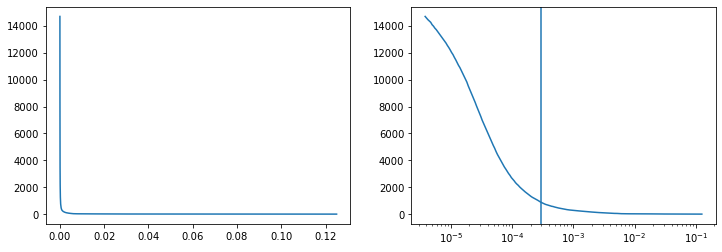

In [32]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(list(n_ambient.keys()),list(n_ambient.values()))
ax[1].plot(list(n_ambient.keys()),list(n_ambient.values()))
ax[1].set_xscale('log')
ax[1].axvline(0.0003)

In [6]:
# Extract ambient genes at selected threshold
thr=0.0003
ambient=set()
for study,folder in ambient_data:
    ambient_df=pd.read_table(folder+"ambient_genes_topN_scores.tsv",index_col=0)
    ambient_study=ambient_df.index[(ambient_df>=thr).any(axis=1)]
    ambient.update(list(ambient_study))
    #print(study,ambient_df.shape,ambient_study.shape)
    print(study,'N ambient:',ambient_study.shape[0])
print('\nN combiend ambient:',len(ambient))

Fltp_2y N ambient: 262
Fltp_adult N ambient: 225
Fltp_P16 N ambient: 275
NOD N ambient: 300
NOD_elimination N ambient: 376
spikein_drug N ambient: 409
embryo N ambient: 583
VSG N ambient: 320
STZ N ambient: 256

N combiend ambient: 876


## Ambient genes clusters
Cluster top ambient genes and analyse their expression across cell types and on beta cells to mark top ambient genes coming from non-beta cells (for postnatal analysis).

#### Cluster cells to use as subpopulations that may generate ambient genes.

Subset to non-embryo data to recalculate embedding and clusters - since we are interested in postnatal ambient genes.

In [215]:
# remove embryo study
adata_sub=adata[adata.obs.study!='embryo']
adata_sub.shape

(264235, 13999)

In [216]:
# recalculate UMAP on subsetted data
sc.pp.neighbors(adata_sub,n_pcs=0,use_rep='X_integrated')
sc.tl.umap(adata_sub)

In [217]:
# Compute fine clusters
res=2
sc.tl.leiden(adata_sub,resolution=res,key_added='leiden_r'+str(res))

In [18]:
ct_col='cell_type_integrated_v1'

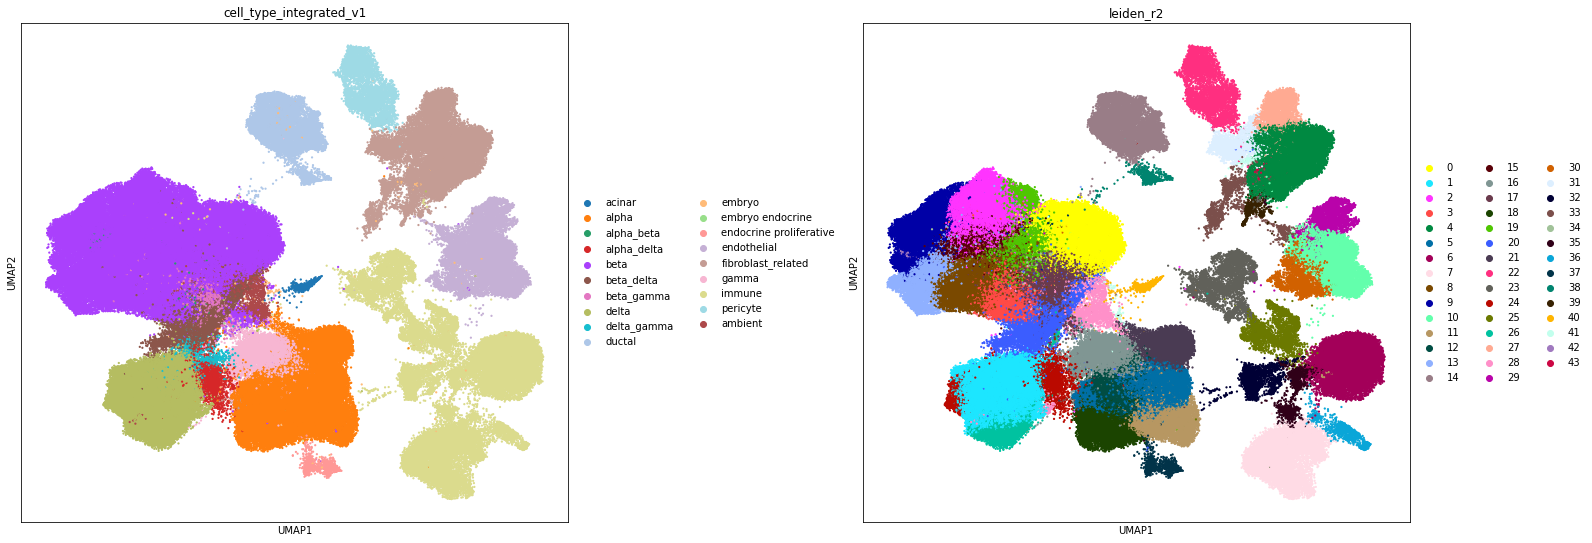

In [218]:
# Cell types and fine clusters
rcParams['figure.figsize']=(9,9)
sc.pl.umap(adata_sub,color=[ct_col]+['leiden_r'+str(res)],wspace=0.4,s=20,ncols=2)

In [25]:
# Clusters used for computing gene similarity
cl_col='leiden_r2'

Correspondence between cl (cluster) and ct (cell type) scaled by rows.

<AxesSubplot:xlabel='leiden_r2', ylabel='cell_type_integrated_v1'>

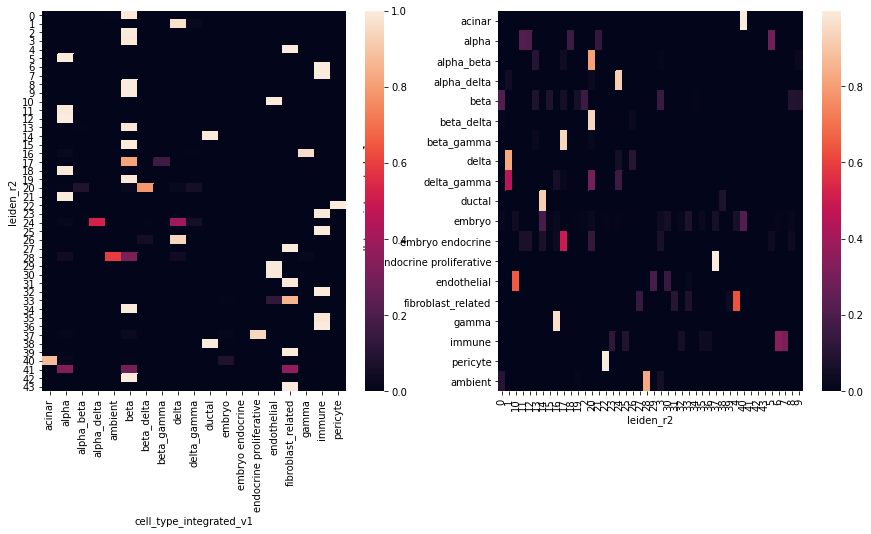

In [219]:
# Correspondence between cl and ct
confusion_cl=adata_sub.obs.groupby([cl_col])[
    ct_col].value_counts(normalize=True).unstack().fillna(0)
confusion_ct=adata_sub.obs.groupby([ct_col])[
    cl_col].value_counts(normalize=True).unstack().fillna(0)
fig,ax=plt.subplots(1,2,figsize=(15,7))
sb.heatmap(confusion_cl,xticklabels=True,yticklabels=True,ax=ax[0])
sb.heatmap(confusion_ct,xticklabels=True,yticklabels=True,ax=ax[1])

Find beta clusters

In [220]:
# Find clusters with many beta cells (>10%)
beta_cls=set()
for cl in adata_sub.obs[cl_col].unique():
    ct_ratios=adata_sub[adata_sub.obs[cl_col]==cl,:].obs[ct_col].value_counts(normalize=True)
    if  'beta' in ct_ratios.index and ct_ratios['beta']>0.1:
        print(cl,'size:',adata_sub[adata_sub.obs[cl_col]==cl,:].shape[0])
        print(ct_ratios)
        beta_cls.add(cl)

2 size: 16217
beta           0.998520
alpha          0.000432
beta_gamma     0.000370
beta_delta     0.000247
embryo         0.000185
alpha_beta     0.000185
endothelial    0.000062
Name: cell_type_integrated_v1, dtype: float64
9 size: 8849
beta          0.997740
alpha_beta    0.002034
embryo        0.000113
beta_delta    0.000113
Name: cell_type_integrated_v1, dtype: float64
13 size: 8156
beta          0.986390
alpha_beta    0.008215
beta_gamma    0.003923
alpha         0.001349
beta_delta    0.000123
Name: cell_type_integrated_v1, dtype: float64
15 size: 8026
beta          0.998131
beta_delta    0.001495
embryo        0.000374
Name: cell_type_integrated_v1, dtype: float64
17 size: 6883
beta                0.813453
beta_gamma          0.165190
gamma               0.005811
alpha_beta          0.003632
delta_gamma         0.003487
alpha               0.003342
embryo endocrine    0.002179
beta_delta          0.001308
ambient             0.000872
delta               0.000581
embryo       

C: Cluster 28 will not be regarded as beta as it has mainly poor quality cells. Cluster 41 will also not be regarded as beta as it is very mixed.

In [221]:
# Remove the two clusters
beta_cls.remove('28')  
beta_cls.remove('41') 
print(beta_cls)

{'15', '13', '0', '19', '3', '17', '2', '8', '34', '9', '42'}


#### Compute gene clusters

Prepare mean gene expression data across clusters

In [248]:
# Add cell cl and ct and UMAP info to rawnorm adata
adata_sub_rawnorm=adata_rawnorm[adata_sub.obs_names,:].copy()
adata_sub_rawnorm.obs[cl_col]=adata_sub.obs[cl_col].copy()
adata_sub_rawnorm.obs[ct_col]=adata_sub.obs[ct_col].copy()
adata_sub_rawnorm.obsm['X_umap']=adata_sub.obsm['X_umap'].copy()
adata_sub_rawnorm.obsp['connectivities']=adata_sub.obsp['connectivities'].copy()
adata_sub_rawnorm.obsp['distances']=adata_sub.obsp['distances'].copy()
# remove any previous info on scores
adata_sub_rawnorm.obs.drop([col for col in adata_sub_rawnorm.obs.columns
                        if 'ambient_score_cluster' in col],axis=1,inplace=True)

In [225]:
# Make df of ambient genes vs mean expression across cell clusters 
cell_cls=adata_sub.obs[cl_col].unique()
ambient_features=pd.DataFrame(index=ambient,columns=cell_cls)
for cell_cl in cell_cls:
    ambient_features[cell_cl]=np.array(adata_sub_rawnorm[
        adata_sub.obs[cl_col]==cell_cl,ambient_features.index].X.mean(axis=0)).ravel()

In [226]:
# prepare gene data for clustering
adata_genes=anndata.AnnData(ambient_features)

Leiden clustering of genes

In [227]:
# Embedding of genes for leiden
# Here vars should be at same scale as they are across cells and cells are all scaled - so
# no scaling is needed????
sc.pp.neighbors(adata_genes,use_rep='X',metric='correlation',knn=5) 
sc.tl.leiden(adata_genes,resolution=1)
sc.tl.umap(adata_genes)

In [228]:
# Cluster genes leiden
sc.tl.leiden(adata_genes,resolution=2)
print('N gene clusters:',adata_genes.obs.leiden.nunique())

N gene clusters: 18


#### Analyse gene clusters

In [232]:
#Add better colors to leiden clusters
adata_genes.uns['leiden_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown']

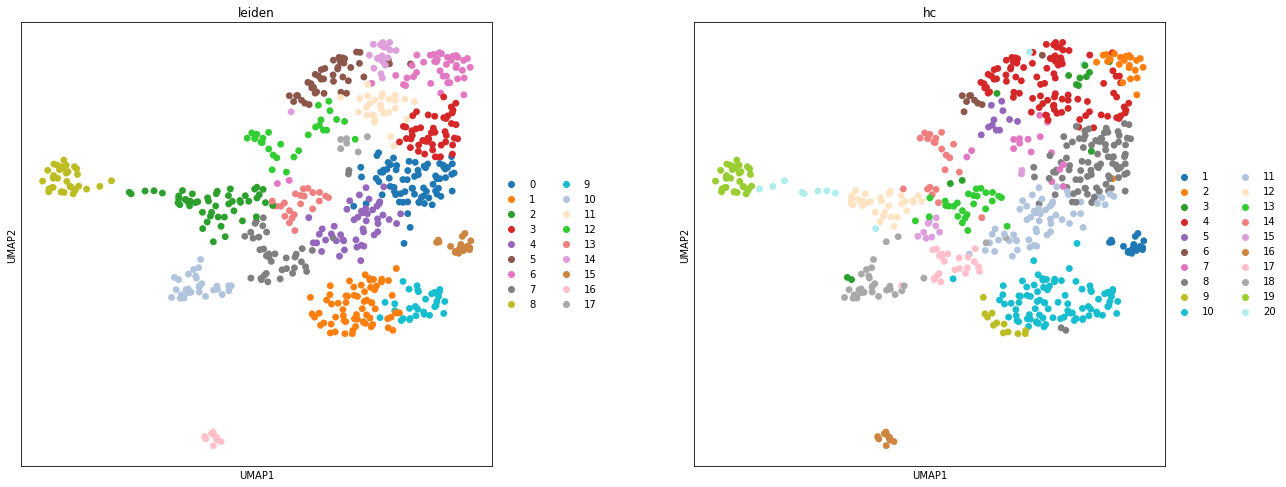

In [233]:
sc.pl.umap(adata_genes,color=['leiden','hc'],wspace=0.3)

Compute gene scores for ambient clusters across cells

In [250]:
# Ambient gene cluster scores
gene_cl='leiden'
for ct in adata_genes.obs[gene_cl].unique():
    score_name='ambient_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_sub_rawnorm, 
                      gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_sub_rawnorm.obs[score_name+'_scaled']=minmax_scale(adata_sub_rawnorm.obs[score_name])

Plot ambient cl gene expression (via scores) across cell clusters

In [235]:
# Row colors for heatmap, containing cell type info
ct_color_map=dict(zip(adata_sub.obs[ct_col].cat.categories,adata_sub.uns[ct_col+'_colors']))
cl_names=adata_sub.obs[cl_col].unique()
row_colors=pd.DataFrame({
              'is_beta':['g' if cl in beta_cls else 'r' for cl in cl_names],
            'main_'+ct_col:[ct_color_map[
                adata_sub[adata_sub.obs[cl_col]==cl].obs[ct_col].value_counts().index[0]
            ] for cl in cl_names]
              },index=cl_names)

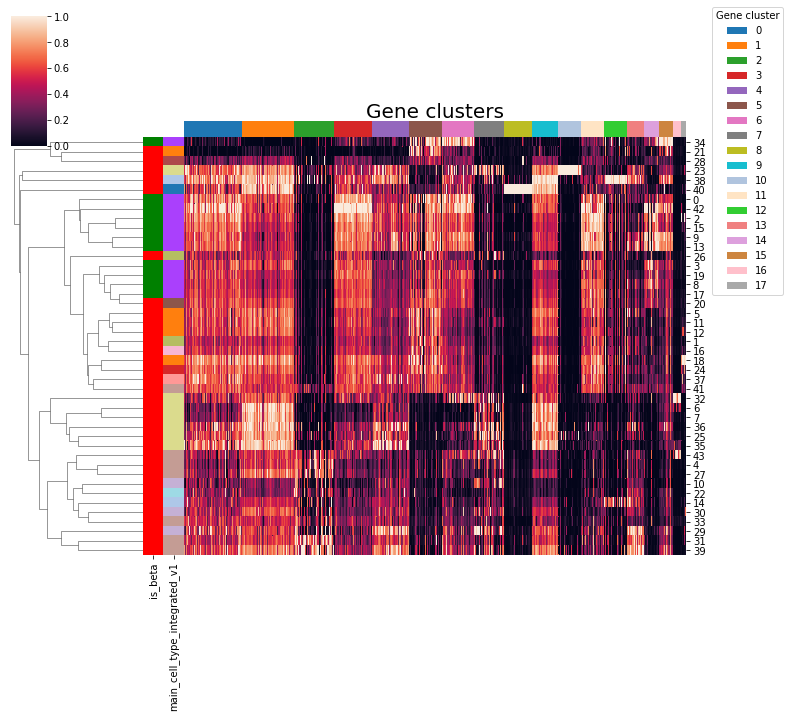

In [239]:
# Prepare data for gene clusters heatmap
# Which clustering to show
gene_clustering='leiden'
# ordered genes by clusters
gene_list=[gene for cl in adata_genes.obs[gene_clustering].cat.categories
           for gene in ambient_features.index[adata_genes.obs[gene_clustering]==cl]]
# ordered gene colors 
cl_list=[adata_genes.uns[gene_clustering+'_colors'][idx] for idx,cl in 
         enumerate(adata_genes.obs[gene_clustering].cat.categories)
         for gene in ambient_features.index[adata_genes.obs[gene_clustering]==cl]]

x_temp=pd.DataFrame(pp.minmax_scale(ambient_features.T),
                    index=ambient_features.columns,columns=ambient_features.index)[gene_list]
fg=sb.clustermap(x_temp.loc[[str(x) for x in sorted([int(x) for x in x_temp.index])],:], 
              col_colors=cl_list, 
              col_cluster=False,row_cluster=True,
             xticklabels=False, yticklabels=True,
                row_colors=row_colors.loc[x_temp.index,:])
 # Adds block annotation titles as axis labels
fg.ax_col_colors.set_xlabel('Gene clusters',fontsize=20)
fg.ax_col_colors.xaxis.set_label_position('top') 
# legend for gene clusters
handles = [Patch(facecolor=c) for c in adata_genes.uns[gene_clustering+'_colors']]
plt.legend(handles, adata_genes.obs[gene_clustering].cat.categories, title='Gene cluster',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)

Ambient gene cluster scores on uMAP

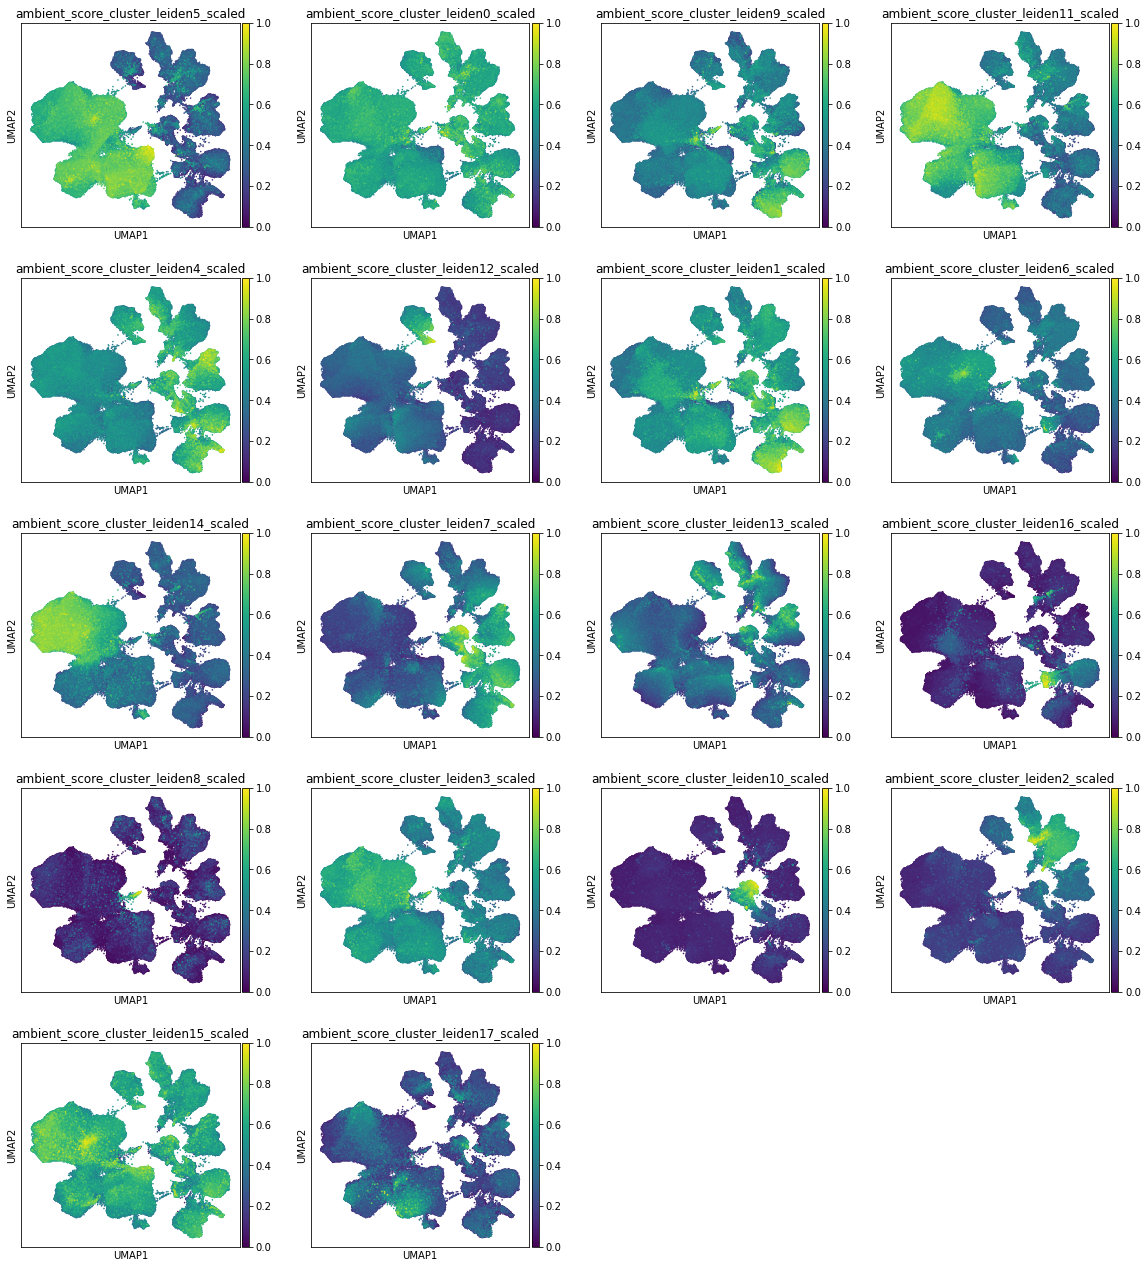

In [251]:
rcParams['figure.figsize']=(4,4)
sc.pl.umap(adata_sub_rawnorm,color=[col for col in adata_sub_rawnorm.obs.columns 
    if 'ambient_score_cluster_leiden' in col and '_scaled' in col], s=10)

#### Extract non-beta ambient genes
Clusters with relatively low expression in beta cells.

In [264]:
# Non-beta ambient clusters
ambient_nobeta_leiden=[cl for cl in adata_genes.obs['leiden'].unique()
                      if cl not in ['0','3','5','6','11','14','15']]
print('Non-beta ambient clusters:',ambient_nobeta_leiden)
ambient_nobeta=adata_genes.obs_names[adata_genes.obs.leiden.isin(ambient_nobeta_leiden)]
print("N non-beta ambient genes:",len(ambient_nobeta))

Non-beta ambient clusters: ['9', '4', '12', '1', '7', '13', '16', '8', '10', '2', '17']
N non-beta ambient genes: 367


### Analyse

#### Ambient beta and non-beta gene numbers

How many non-beta ambient genes are among ambient genes of each study and sample

In [276]:
thr=0.0003
ambient=set()
ambient_missing_integrated=set()
ambient_nonbeta_info=[]
for study,folder in ambient_data:
    ambient_df=pd.read_table(folder+"ambient_genes_topN_scores.tsv",index_col=0)
    genes_anno_temp=genes_anno.copy()
    genes_anno_temp.index=genes_anno_temp['gene_symbol_'+study]
    for col in [col for col in ambient_df.columns if col !='mean_ambient_n_counts']:
        ambient_sample=list(ambient_df.index[ambient_df[col]>=thr])
        # EIDs of ambient genes
        ambient_sample_id=genes_anno_temp.loc[
            [g for g in ambient_sample if g in genes_anno_temp.index],'EID'].values
        sample=col.replace('mean_ambient_n_counts_','')
        ambient_nonbeta_info.append(
            {'study':study,'sample':sample,'study_sample':study+'_'+sample,
             'n_beta_ambient':len(set(ambient_sample_id)-set(ambient_nobeta)),
             'n_nonbeta_ambient':len(set(ambient_sample_id)&set(ambient_nobeta)),
             'n_ambient':len(ambient_sample)
            })
ambient_nonbeta_info=pd.DataFrame(ambient_nonbeta_info)

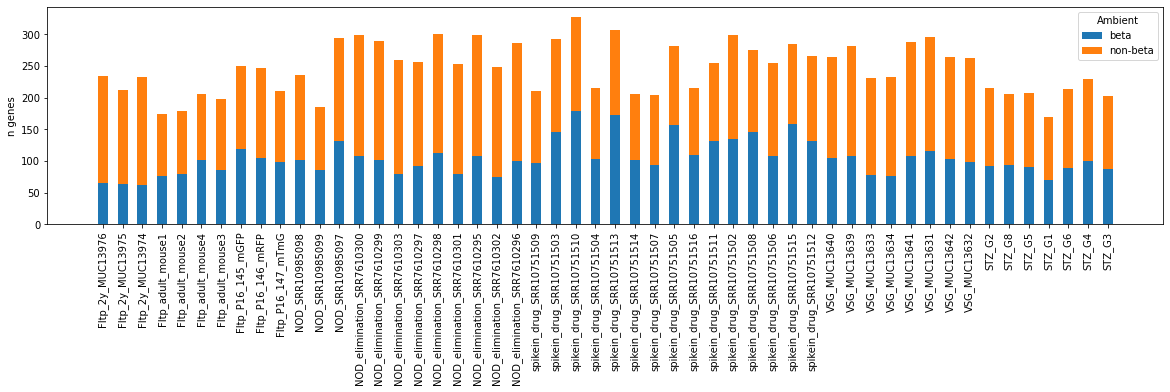

In [286]:
fig, ax = plt.subplots(figsize=(20,4))
ax.bar(ambient_nonbeta_info['study_sample'], ambient_nonbeta_info['n_beta_ambient'], 
       0.5 ,  label='beta')
ax.bar(ambient_nonbeta_info['study_sample'], ambient_nonbeta_info['n_nonbeta_ambient'], 
       0.5 , bottom=ambient_nonbeta_info['n_beta_ambient'],label='non-beta')
a=plt.xticks(rotation=90)
a=ax.legend(title='Ambient')
a=ax.set_ylabel('n genes')

#### Check where are known non-beta ambient genes
Are known non-beta ambient genes (e.g. other hormones, markers of other cts) in beta or non-beta cluster.

In [4]:
# Load gene anno
genes_anno=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genomeAnno_ORGmus_musculus_V103.tsv',
                         index_col=0)

In [29]:
# Known non-beta ambient genes EIDs
known_ct_ambient=['Gcg','Ppy','Pyy','Sst','Cxcl2','Prss2','Cel','Krt19']
genes_anno.index=genes_anno['Gene name']
eids=genes_anno.loc[known_ct_ambient,'EID']
genes_anno.index=genes_anno['EID']
print('Example non-beta ambient genes:',eids)

Example non-beta ambient genes: Gene name
Gcg      ENSMUSG00000000394
Ppy      ENSMUSG00000017316
Pyy      ENSMUSG00000017311
Sst      ENSMUSG00000004366
Cxcl2    ENSMUSG00000058427
Prss2    ENSMUSG00000057163
Cel      ENSMUSG00000026818
Krt19    ENSMUSG00000020911
Name: EID, dtype: object


In [28]:
# In which gene cl are genes
print('Gene cls containing non-beta example ambient genes')
gene_cl[eids]

Gene cls containing non-beta example ambient genes


ENSMUSG00000000394     5
ENSMUSG00000017316     5
ENSMUSG00000017311     5
ENSMUSG00000004366     5
ENSMUSG00000058427    10
ENSMUSG00000057163     8
ENSMUSG00000026818     8
ENSMUSG00000020911    12
Name: leiden, dtype: category
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']

In [27]:
# Which genes were not marked as non-beta
print('Ambient genes from other cts not removed with ambient_nonbeta')
print(genes_anno.loc[[e for e in eids if e not in ambient_nonbeta],'Gene name'])

Ambient genes from other cts not removed with ambient_nonbeta
EID
ENSMUSG00000000394    Gcg
ENSMUSG00000017316    Ppy
ENSMUSG00000017311    Pyy
ENSMUSG00000004366    Sst
Name: Gene name, dtype: object


C: It seems that some genes from other cell types were not removed as they are located in cl 5, which is also high in beta cells (some endocrine genes).

Which other genes are in cluster 5

In [12]:
genes5=gene_cl.index[gene_cl=='5']
print('N genes in cl 5:',len(genes5))
print(genes_anno.loc[genes5,'Gene name'].values.tolist())

N genes in cl 5: 42
['Gcg', 'Cd164', 'Syt13', 'Aplp1', 'Pyy', 'Pcsk2', 'C2cd4b', 'Rgs4', 'Rsrp1', 'Itm2c', 'Cltrn', 'Gpx3', 'Ttr', 'Pam', 'Sst', 'Prnp', 'Pcsk1n', 'Ppy', 'Cck', 'Rbp4', 'Ccnd2', 'Nenf', 'Abcc8', 'Maged1', 'Wnt4', 'Scg3', 'Iapp', 'Chga', 'Meg3', 'Scg2', 'Resp18', 'Chgb', 'Cpe', 'Gnas', 'Ptprn', 'Cst3', 'Slc30a8', 'Tmed3', 'Scg5', 'Dapl1', 'Peg3', 'Ffar4']


C: Besides hormones from other cell types this cluster also contains interesting genes like Rbp4, Chga, Chgb, Wnt4, ... Thus it will not be removed. If needed these genes can be removed later in downstream analyses.

#### Save data

Save ambient genes not commming from beta cells

In [288]:
pickle.dump(
    # Also save ambinet threshold at which genew were obtained so 
    # that same filtering can be used lattere
    {'ambient_thr':thr,'ambient_nonbeta':ambient_nobeta},
    open(path_save_ambient+'ambient_nonbeta.pkl','wb'))

Save used clustering information

In [262]:
pickle.dump({'cell_cl':adata_sub.obs[cl_col], 'gene_cl':adata_genes.obs['leiden']},
            open(path_save_ambient+'ambient_clustering.pkl','wb'))